# Проект классификации комментариев

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо построить модель со значением метрики качества *F1* не меньше 0.75 для классификации комментариев на позитивные и негативные.

**Цель проекта**: построить модель для поиска токсичных комментариев. 

**Шаги проекта**:
- подготовить данные,
- проверить датасет на сбалансированность,
- очистить и лемматизировать текст,
- создать и почистить мешок слов,
- разделить данные на выборки и определить целевой признак,
- вычислить TF-IDF для тренировочной и тестовой выборок,
- обучить модели логистическая регрессия и CatBoostClassifier,
- сделать выводы.

## Подготовка

In [214]:
import sys
!{sys.executable} -m pip install spacy
# Download spaCy's  'en' Model
!{sys.executable} -m spacy download en
from sklearn.feature_extraction.text import CountVectorizer

     --------------------------------------- 12.8/12.8 MB 10.7 MB/s eta 0:00:00
[!] As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use
the full pipeline package name 'en_core_web_sm' instead.
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [215]:
pip install catboost --no-cache-dir

Note: you may need to restart the kernel to use updated packages.


In [216]:
conda install -c conda-forge pandarallel

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [217]:
conda install -c conda-forge lightgbm

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [218]:
conda install -c conda-forge wordcloud

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [219]:
import pandas as pd
import nltk
import spacy
import re 
import time
import catboost
import requests
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from pymystem3 import Mystem
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer


from nltk import word_tokenize
from nltk.probability import FreqDist


from catboost import CatBoostClassifier

from tqdm import tqdm
from pandarallel import pandarallel
from sklearn.preprocessing import StandardScaler

### Откроем и изучим данные

In [222]:
try:

    data = pd.read_csv(r'C:\Users\User\Desktop\DS\Projects\Викишоп МО для текстов\toxic_comments.csv', index_col = 0)
except:

    data = pd.read_csv('/datasets/toxic_comments.csv', index_col = 0)  

In [223]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [224]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Пропусков не обнаружено, типы данных соответсвуют.

In [226]:
data.sample(10)

,text,toxic
78900,Edit request on 30 December 2011 \n\nPlease ad...,0
82785,Public apology \n\nI hereby make a public apol...,0
140378,Contested deletion \n\nThis page is not unambi...,0
86108,Please stop. If you continue to vandalize page...,0
500,Protecting 'Causes of the 1948 Palestinian exo...,0
151174,"""\n\n baiting Paul \n\nI don't think its entir...",0
148057,Each tradition is as good as another. So Im ha...,0
139006,"""\nWhy? Does one need a """"stake"""" in something...",0
33981,"""\n\nTalkback\n\nI regret Sir. I shall be more...",0
78780,Dinosaur \nSupport given. I have always read t...,0


### Проверим датасет на сбалансированность

In [227]:
toxic = data['toxic'].value_counts()

In [228]:
data_balance = pd.Series(toxic)
data_balance

0    143106
1     16186
Name: toxic, dtype: int64

In [229]:
toxic_rate = data_balance[1]*100/(data_balance[0]+data_balance[1])
toxic_rate

10.161213369158526

Таким образом, можно сделать вывод, что данные несбалансированы: 10 процентов приходится на токсичные комментарии. Точность модели для проверки адекватности должна быть более 0,89.

### Очистим и лемматизируем текст, приведем к нижнему регистру

In [230]:
data['text'] = data['text'].str.lower()

In [231]:
def clear_text(text):
    lemm_engl = re.sub(r'[^a-zA-Z ]', ' ', text) 
    lemm_no_space = lemm_engl.split()
    lemm = " ".join(lemm_no_space)
    return lemm

In [232]:
tqdm.pandas(desc="progress")

In [233]:
data['clear_text'] = data['text'].progress_apply(clear_text) 

progress: 100%|█████████████████████████████████████████████████████████████| 159292/159292 [00:02<00:00, 54400.45it/s]


In [234]:
%%time
lemm_text=[]


sp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

for i in data['clear_text']:
    doc = sp(i)
    lemm_text.append(" ".join([token.lemma_ for token in doc]))


CPU times: total: 16min 8s
Wall time: 16min 10s


In [235]:
data['lemm_text'] = lemm_text
data.head()

,text,toxic,clear_text,lemm_text
0,explanation\nwhy the edits made under my usern...,0,explanation why the edits made under my userna...,explanation why the edit make under my usernam...
1,d'aww! he matches this background colour i'm s...,0,d aww he matches this background colour i m se...,d aww he match this background colour I m seem...
2,"hey man, i'm really not trying to edit war. it...",0,hey man i m really not trying to edit war it s...,hey man I m really not try to edit war it s ju...
3,"""\nmore\ni can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...,more I can t make any real suggestion on impro...
4,"you, sir, are my hero. any chance you remember...",0,you sir are my hero any chance you remember wh...,you sir be my hero any chance you remember wha...


### Проведем частотный анализ текста

In [239]:
#count_vect = CountVectorizer()
stop_words = set(stopwords.words('english'))

corpus = data['lemm_text']

#corpus = list(corpus)

corpus

0         explanation why the edit make under my usernam...
1         d aww he match this background colour I m seem...
2         hey man I m really not try to edit war it s ju...
3         more I can t make any real suggestion on impro...
4         you sir be my hero any chance you remember wha...
                                ...                        
159446    and for the second time of ask when your view ...
159447    you should be ashamed of yourself that be a ho...
159448    spitzer umm there s no actual article for pros...
159449    and it look like it be actually you who put on...
159450    and I really don t think you understand I come...
Name: lemm_text, Length: 159292, dtype: object

In [240]:
list_for_count = []
for sentance in corpus:
    words_list = sentance.split()
    final_list = [word for word in words_list if word not in stop_words]
    final_string = ' '.join(final_list)
    list_for_count.append(final_string)

In [241]:
nltk.download('punkt')
text_tokens = word_tokenize(str(list_for_count))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [242]:
text = nltk.Text(text_tokens)
fdist = FreqDist(text)
fdist

FreqDist({'I': 278277, "'": 178055, ',': 159291, 'article': 73271, 'page': 56667, 'wikipedia': 47744, 'talk': 39867, 'edit': 36198, 'use': 32886, 'one': 30068, ...})

Определим 20 наиболее часто встречающихся слов и визулизируем их

In [243]:
fdist.most_common(20)

[('I', 278277),
 ("'", 178055),
 (',', 159291),
 ('article', 73271),
 ('page', 56667),
 ('wikipedia', 47744),
 ('talk', 39867),
 ('edit', 36198),
 ('use', 32886),
 ('one', 30068),
 ('make', 30043),
 ('would', 28913),
 ('like', 28434),
 ('see', 26665),
 ('please', 26203),
 ('say', 24945),
 ('think', 24659),
 ('know', 23665),
 ('source', 22972),
 ('get', 22174)]

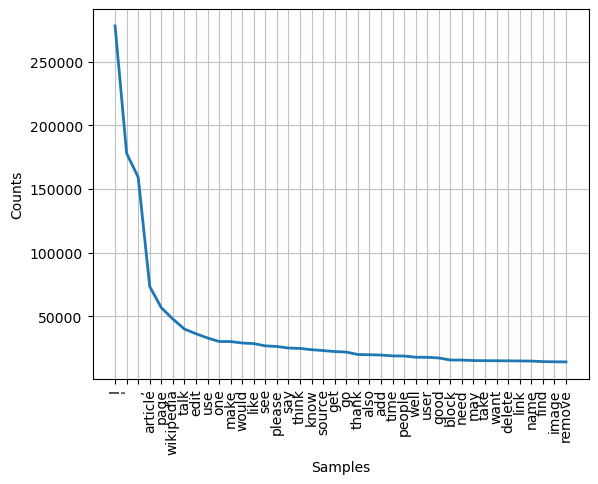

<Axes: xlabel='Samples', ylabel='Counts'>

In [244]:
fdist.plot(40,cumulative=False)

Визуализируем популярные слова в виде облака слов

In [245]:
%matplotlib inline

In [246]:
text_raw = " ".join(text)

In [247]:
wordcloud = WordCloud().generate(str(text_tokens))

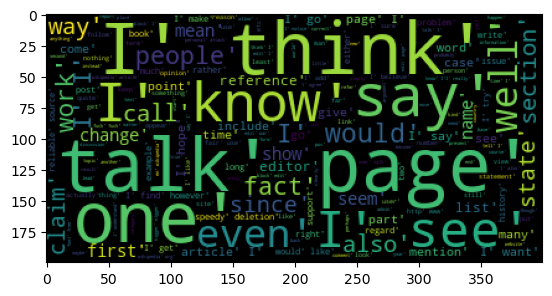

In [248]:
plt.imshow(wordcloud)

### Разделим данные на выборки, учитывая дисбаланс

In [251]:
train, test = train_test_split(data, train_size=0.80, random_state=12345, stratify=data['toxic'])

In [252]:
i = train, test
for x in i:
    print(x.shape)

(127433, 4)
(31859, 4)


In [253]:
toxic_train = test['toxic'].value_counts()
train_balance = pd.DataFrame(toxic_train)

In [254]:
toxic_train_rate = data_balance[1]*100/(data_balance[0]+data_balance[1])
toxic_train_rate

10.161213369158526

Дисбаланс в выборках равен дисбалансу в исходных данных

### Вычислим TF-IDF для тренировочной и тестовой выборок

In [255]:
stop_words = set(stopwords.words('english'))
st = list(stop_words)

In [256]:
count_tf_idf = TfidfVectorizer(stop_words=st) 
tf_idf_train = count_tf_idf.fit_transform(train['lemm_text']) 

In [257]:
tf_idf_train.shape

(127433, 132996)

In [258]:
tf_idf_test = count_tf_idf.transform(test['lemm_text']) 
tf_idf_test.shape

(31859, 132996)

### Определим целевой признак

In [259]:
features_train = tf_idf_train
features_test = tf_idf_test

target_train = train['toxic']
target_test = test['toxic']

## Обучение

### Обучим модель логистическая регрессия

In [260]:
#f1_scorer = make_scorer(f1_score)
pipe = make_pipeline(StandardScaler(with_mean=False), 
                     LogisticRegression(max_iter=200, solver='liblinear', class_weight='balanced'))
model_lr = pipe.fit(features_train, target_train)
prediction_lr = model_lr.predict(features_test)
f1_lr = f1_score(target_test, prediction_lr)

In [261]:
f1_lr

0.6354617856643846

Таким образом, метрика качества модели составляет 0,63, попробуем автоматически подобрать гиперпараметры и проверим, улучшит ли это результат.

In [262]:
f1_scorer = make_scorer(f1_score)

In [263]:
%%time
model = LogisticRegression(random_state = 12345)
params_lr={'penalty': ['l1', 'l2', 'elasticnet', None],
           'max_iter': [100, 200, 300],
           #'multi_class' : ['auto', 'ovr', 'multinomial'],
           #'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
           'C': range(1, 10, 2),
           'class_weight': [1, 'balanced']}

lr = RandomizedSearchCV(model, params_lr, n_iter=20, scoring=f1_scorer, n_jobs=-1, cv=3)
lr.fit(features_train, target_train)
model_params= lr.best_estimator_

C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
54 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1160, in fit
    self._validate_params()
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\base.py", line 581, in _validate_params
    validate_parameter_constraints(
  File "C:\ProgramData\anaconda3\lib\site-

CPU times: total: 33.2 s
Wall time: 45.5 s


C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [264]:
model_params

LogisticRegression(C=7, class_weight='balanced', random_state=12345)

In [265]:
f1 = lr.best_score_
f1

0.7657561847828837

In [266]:
%%time
params_lr1={#'max_iter': [100, 200, 300],
           #'multi_class' : ['auto', 'ovr', 'multinomial'],
           #'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
           #'C': range(1, 10, 2),
           #'class_weight': [1, 'balanced']
}
pipeline = make_pipeline(LogisticRegression())


lr1 = RandomizedSearchCV(pipeline, params_lr1, n_iter=20, scoring=f1_scorer, n_jobs=-1, cv=3)
lr1.fit(features_train, target_train)
model_params1= lr1.best_estimator_

C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


CPU times: total: 18.6 s
Wall time: 11.9 s


C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [267]:
f1 = lr1.best_score_
f1

0.7126301058439489

Автоматический подбор гиперпараметров позволил улучшить метрику f1 до 0.766, что соответствует заявленным требованиям

### Обучим модель CatBoostClassifier

In [269]:
model_cbc = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    custom_loss=['F1'],
    auto_class_weights='Balanced'
)

In [270]:
%%time
model_cbc.fit(features_train, target_train,
          verbose=False,
              plot=True,
              use_best_model=True
              
)

print(f"Model params: {model_cbc.get_params()}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

You should provide test set for use best model. use_best_model parameter has been switched to false value.


Model params: {'iterations': 300, 'learning_rate': 0.1, 'auto_class_weights': 'Balanced', 'custom_loss': ['F1']}
CPU times: total: 36min 28s
Wall time: 6min 52s


In [271]:
model_cbc.best_score_ 

{'learn': {'F1:use_weights=false': 0.7739340305711988,
  'Logloss': 0.2682594113528366,
  'F1:use_weights=true': 0.9020088414140788}}

Таким образом, лучший параметр f1 для модели CatBoostClassifier - 0.90

Протеститруем модель, показавшую дучшую метрику качества F1

In [279]:
predictions_test_cbc = model_cbc.predict(features_test)

In [280]:
f1 = f1_score(target_test, predictions_test_cbc)
f1

0.750561797752809

## Выводы

Таким образом, по итогам проделанной работы мы можем сделать следующие выводы:

- пропусков не обнаружено, типы данных соответсвуют заявленным, удален неинформативный столбец;
- данные несбалансированы: 10 процентов приходится на токсичные комментарии;
- текст очищен и лемматизирован, проведен частотный анализ текста;
- данные разделены на выборки и опреден целевой признак,
- вычислен TF-IDF для тренировочной и тестовой выборок,
- обучены модели логистическая регрессия и CatBoostClassifier;
- лучший результат метрики f1 для Логистической регрессии - 0,766, для CatBoostClassifier - 0.90, время подсчета - 14 и 25 минут соответсвенно.

Проверка модели на тестовых данных показала результат метрики f1 - 0.75, что соответсвует заявленным требованиям

Таким образом, применение модели CatBoostClassifier на основе метода оценки важности слов TF-IDF может быть рекомендована для поиска токсичных комментариев в проекте Викишоп.